# Brick optimisation normalisation check

Created 22/08/2024

Objectives:
* Have reason to believe (from brick_optimisation_layer_automation) that the mps normalisation is decaying with each layer. Check and correct if needs be.
* Will need to do something similar for the mpo w tensors as well as the mps b tensors.

# Package imports

In [1]:
import sys
sys.path.append('../')

In [2]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [3]:
from functools import reduce
from operator import mul

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries

from SPTOptimization.Optimizers.OneSiteSolver import OneSiteSolver

from SPTOptimization.utils import (
    to_npc_array,
    get_right_identity_environment,
    multiply_transfer_matrices
)

from SPTOptimization.Optimizers.utils import (
    one_site_optimization_sweep_right
)

In [6]:
import re

# Load data

In [7]:
DATA_DIR = r"../data/transverse_cluster_200_site_dmrg"

In [8]:
f_name = DATA_DIR + r"/0_90.h5"

In [9]:
f_name

'../data/transverse_cluster_200_site_dmrg/0_90.h5'

In [10]:
with h5py.File(f_name, 'r') as f:
    data = hdf5_io.load_from_hdf5(f)
    test_psi = data['wavefunction']

# Definitons

In [11]:
MAX_VIRTUAL_BOND_DIM = 8
MAX_INTERMEDIATE_VIRTUAL_BOND_DIM = 2*MAX_VIRTUAL_BOND_DIM

SVD_CUTOFF = 1e-3

In [12]:
np_I = np.array([[1,0],[0,1]])
np_X = np.array([[0,1],[1,0]])
np_Y = np.array([[0,-1j],[1j,0]])
np_Z = np.array([[1,0],[0,-1]])

In [13]:
npc_I = to_npc_array(np_I)
npc_X = to_npc_array(np_X)
npc_Y = to_npc_array(np_Y)
npc_Z = to_npc_array(np_Z)

In [14]:
test = SymmetryActionWithBoundaryUnitaries(
    test_psi,
    [np_X, np_I]*50
)

In [15]:
test.compute_svd_symmetry_action()

In [16]:
test.right_projected_symmetry_state

<npc.Array shape=(8, 8) labels=['vR', 'vR*']>

In [17]:
test.left_projected_symmetry_state

<npc.Array shape=(8, 8) labels=['vL', 'vL*']>

In [18]:
left_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=1
)

In [19]:
right_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=-1
)

## Functions

### Leg and label functions

In [20]:
P_LEG_LABEL_REGEX_STRING = r"^p\d*$"
p_leg_pattern = re.compile(P_LEG_LABEL_REGEX_STRING)

def is_single_physical_leg_label(label):
    return bool(p_leg_pattern.match(label))

In [21]:
def is_grouped_physical_leg_label(leg_label):
    head, *body, tail = leg_label
    if (head != '(') or (tail != ')'):
        return False

    body = ''.join(body)
    legs = body.split('.')

    return all(is_single_physical_leg_label(l) for l in legs)

In [22]:
def is_physical_leg_label(label):
    out = (
        is_single_physical_leg_label(label)
        or is_grouped_physical_leg_label(label)
    )

    return out

In [23]:
def extract_single_physical_leg_label_from_tensor(b):
    out = next(
        l for l in b.get_leg_labels()
        if is_single_physical_leg_label(l)
    )

    return out

In [24]:
def conjugate_single_physical_leg_label(label):
    return label + '*'

In [25]:
def conjugate_grouped_physical_leg_label(label):
    _, *body, _ = label
    single_labels = ''.join(body).split('.')

    conjugate_labels = [
        conjugate_single_physical_leg_label(l)
        for l in single_labels
    ]

    conjugate_body = '.'.join(conjugate_labels)
    out = '(' + conjugate_body + ')'
    
    return out

In [26]:
def conjugate_leg_label(label):
    if is_single_physical_leg_label(label):
        return conjugate_single_physical_leg_label(label)
    elif is_grouped_physical_leg_label(label):
        return conjugate_grouped_physical_leg_label(label)
    else:
        raise ValueError

In [27]:
def get_physical_leg_labels(t):
    out = [
        ll for ll in t.get_leg_labels()
        if is_physical_leg_label(ll)
    ]

    return out

### Other

In [28]:
def contract_virtual_legs(tl, tr):
    return npc.tensordot(tl, tr, ['vR', 'vL'])

In [29]:
def combine_tensors(tensors):
    out = reduce(contract_virtual_legs, tensors)

    leg_labels = [
        extract_single_physical_leg_label_from_tensor(t)
        for t in tensors
    ]

    out = out.combine_legs(leg_labels)

    return out

In [30]:
def combine_b_tensors(b_tensors):
    renamed_tensors = [
        b.replace_label('p', f'p{i}')
        for i, b in enumerate(b_tensors)
    ]

    return combine_tensors(renamed_tensors)

In [31]:
def get_identity_operator(mps_tensor):
    p_leg_label = get_physical_leg_labels(mps_tensor)[0]
    p_leg = mps_tensor.get_leg(p_leg_label)
    p_leg_label_conj = conjugate_leg_label(p_leg_label)

    out = npc.diag(
        1,
        leg=p_leg,
        dtype='complex',
        labels=[p_leg_label, p_leg_label_conj]
    )

    return out

In [32]:
def svd_reduce_split_tensor(t, max_inner_dim=MAX_VIRTUAL_BOND_DIM,
                           normalise=True, svd_cutoff=SVD_CUTOFF):
    U, S, VH = npc.svd(
        t,
        compute_uv=True,
        inner_labels=['vR', 'vL'],
        cutoff=svd_cutoff
    )

    # Truncate tensors:
    U = U[:, :max_inner_dim]
    S = S[:max_inner_dim]
    VH = VH[:max_inner_dim, :]

    if normalise:
        new_norm = np.sqrt(np.sum(S**2))
        S = S/new_norm

    """
    leg = VH.get_leg('vL')

    schmidt_values = npc.diag(S, leg, labels=['vL', 'vR'])
    """

    return U, S, VH

To-do: 
* Update initalisation for schmidt values.
* Update svd_reduce_split_tensor function to output schmidt values
* Check if boundary conditions on compression change anything.
* Implement compress sweep at each layer. (Ignore for now.)
* For unitaries, just do same thing? Combine upper and lower legs...? But do we need to normalise in that case...
    * Nees further investigation. Check out transfer matrices and their trace.

In [33]:
def split_combined_b(b, leftmost_schmidt_values,
                     max_virtual_bond_dim=MAX_INTERMEDIATE_VIRTUAL_BOND_DIM,
                     p_leg_labels=None):
    t = b.split_legs()

    num_sites = t.ndim - 2

    if p_leg_labels is None:
        p_leg_labels = [f'p{i}' for i in range(num_sites)]

    out_bs = list()
    out_schmidt_values = list()

    current_left_schmidt_values = leftmost_schmidt_values

    for i, ll in enumerate(p_leg_labels[:-1]):
        t.iscale_axis(current_left_schmidt_values, axis='vL')

        tail_legs = p_leg_labels[(i+1):]
        
        t = t.combine_legs([['vL', ll], ['vR', *tail_legs]])

        U, S, VH = svd_reduce_split_tensor(
            t,
            max_inner_dim=max_virtual_bond_dim,
            normalise=True
        )

        bl = (
            U
            .split_legs()
            .replace_label(ll, 'p')
        )
        bl.iscale_axis(1/current_left_schmidt_values, axis='vL')
        bl.iscale_axis(S, axis='vR')
        bl.itranspose(['vL', 'p', 'vR'])
        out_bs.append(bl)

        out_schmidt_values.append(S)
        current_left_schmidt_values=S

        t = VH.split_legs()

    bl = t.replace_label(p_leg_labels[-1], 'p')
    bl.itranspose(['vL', 'p', 'vR'])
    out_bs.append(bl)

    return out_bs, out_schmidt_values

In [34]:
def split_b(b, max_virtual_bond_dim=MAX_INTERMEDIATE_VIRTUAL_BOND_DIM,
                     p_leg_labels=None):
    leg_label = get_physical_leg_labels(b)[0]

    if is_single_physical_leg_label(leg_label):
        return b
    elif is_grouped_physical_leg_label(leg_label):
        return split_combined_b(b, max_virtual_bond_dim, p_leg_labels)
    else:
        raise ValueError

In [35]:
def split_combined_u(u, max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM,
                     p_leg_labels=None):
    t = u.split_legs()
    num_sites = t.ndim //2
    
    if p_leg_labels is None:
        p_leg_labels = [f'p{i}' for i in range(num_sites)]

    p_leg_labels_hc = [l+'*' for l in p_leg_labels]
    out_ws = list()

    for i, (ll, ll_hc) in enumerate(zip(p_leg_labels[:-1], p_leg_labels_hc[:-1])):
        tail_legs = p_leg_labels[(i+1):]
        tail_legs_hc = p_leg_labels_hc[(i+1):]

        left_leg_labels = [ll, ll_hc]
        if 'vL' in t.get_leg_labels():
            left_leg_labels.append('vL')
    
        t = t.combine_legs([left_leg_labels, [*tail_legs, *tail_legs_hc]])

        U, S, VH = svd_reduce_split_tensor(
            t,
            max_inner_dim=max_virtual_bond_dim,
            normalise=False
        )

        U.iscale_axis(S, axis='vR')

        wl = U.split_legs().replace_labels([ll, ll_hc], ['p', 'p*'])
        #wl.itranspose(['p', 'p*'])
        out_ws.append(wl)

        t = VH.split_legs()

    wl = t.replace_labels(
        [p_leg_labels[-1], p_leg_labels_hc[-1]],
        ['p', 'p*']
    )
    #wl.itranspose(['p', 'p*'])
    out_ws.append(wl)

    out_ws[0] = (
        out_ws[0]
        .add_leg(left_trivial_leg_charge, 0, label='vL')
    )
    
    out_ws[-1] = (
        out_ws[-1]
        .add_leg(right_trivial_leg_charge, 0, label='vR')
    )

    return out_ws

In [36]:
def split_u(u, max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM,
            p_leg_labels=None):
    leg_label = get_physical_leg_labels(u)[0]

    if is_single_physical_leg_label(leg_label):
        return [unitary_to_mpo_tensor(u),]
    elif is_grouped_physical_leg_label(leg_label):
        return split_combined_u(u, max_virtual_bond_dim, p_leg_labels)
    else:
        raise ValueError

In [37]:
def unitary_to_mpo_tensor(u):
    out = (
        u
        .add_leg(left_trivial_leg_charge, 0, label='vL')
        .add_leg(right_trivial_leg_charge, 0, label='vR')
    )

    return out

In [38]:
def multiply_individual_mpo_tensors(w1, w2):
    w1 = w1.replace_labels(['vR', 'vL'], ['vR1', 'vL1'])
    w2 = w2.replace_labels(['vR', 'vL'], ['vR2', 'vL2'])

    w = (
        npc.tensordot(w1, w2, [['p'], ['p*']])
        .combine_legs([['vR1', 'vR2'], ['vL1', 'vL2']])
        .replace_labels(['(vR1.vR2)', '(vL1.vL2)'], ['vR', 'vL'])
    )

    return w

In [39]:
def group_elements(l, group_size, offset=0):
    first, rest = l[:offset], l[offset:]

    num_rest_groups = ((len(rest)-1)//group_size) + 1

    groups = [first,] if first else list()

    for i in range(num_rest_groups):
        first_index = i*group_size
        last_index = (i+1)*group_size
        groups.append(rest[first_index:last_index])

    return groups

In [40]:
def combine_grouped_b_tensors(grouped_bs):
    out = list()

    for group in grouped_bs:
        if len(group) == 1:
            out.append(group[0])
        else:
            out.append(combine_b_tensors(group))

    return out

In [41]:
def reduce_virtual_mpo_dim(wl, wr, max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM):
    # wl = wl.replace_labels(['p', 'p*'], ['pl', 'pl*'])

    wl = wl.combine_legs(['p', 'vL', 'p*'])
    wr = wr.combine_legs(['p', 'vR', 'p*'])
    w = npc.tensordot(wl, wr, ['vR', 'vL'])

    wl, S, wr = svd_reduce_split_tensor(
        w,
        max_inner_dim=max_virtual_bond_dim
    )

    wl.iscale_axis(S, axis='vR')

    wl = wl.split_legs()
    wr = wr.split_legs()

    return wl, wr

In [42]:
def multiply_mpos(top_ws, bottom_ws, max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM):
    ws = list()
    
    for w1, w2 in zip(top_ws, bottom_ws):
        w = multiply_individual_mpo_tensors(w1, w2)
        ws.append(w)


    for i in range(len(ws)-1):
        ws[i], ws[i+1] = reduce_virtual_mpo_dim(
            ws[i],
            ws[i+1],
            max_virtual_bond_dim=max_virtual_bond_dim
        )

    return ws

### Layer function

In [43]:
def optimise_layer(
        left_environment,
        top_b_tensors,
        left_schmidt_values,
        block_width,
        block_offset,
        expectations,
        previous_mpo_w_tensors,
        bottom_b_tensors=None,
        num_iterations=1,
        max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM
    ):

    if bottom_b_tensors is None:
        bottom_b_tensors = top_b_tensors

    group = lambda x: group_elements(x, block_width, block_offset)
    top_grouped_bs = group(top_b_tensors)
    bottom_grouped_bs = group(bottom_b_tensors)
    grouped_schmidt_values = group(left_schmidt_values)

    top_combined_bs = combine_grouped_b_tensors(top_grouped_bs)
    bottom_combined_bs = combine_grouped_b_tensors(bottom_grouped_bs)

    unitaries = [
        get_identity_operator(t) for t in top_combined_bs
    ]

    expectations.append(list())

    for _ in range(num_iterations):
        exps, *_ = one_site_optimization_sweep_right(
            left_environment,
            top_combined_bs,
            unitaries,
            bottom_combined_bs
        )

        expectations[-1].append(exps)

    for i, u in enumerate(unitaries):
        b = top_combined_bs[i]
        ll = get_physical_leg_labels(b)[0]
        llh = conjugate_leg_label(ll)
    
        new_b = npc.tensordot(b, u, [[ll,], [llh,]])
    
        top_combined_bs[i] = new_b

    new_top_bs = list()
    new_left_schmidt_values = left_schmidt_values.copy()

    for b, s in zip (top_combined_bs, grouped_schmidt_values):
        leg_label = get_physical_leg_labels(b)[0]
        if is_single_physical_leg_label(leg_label):
            new_top_bs.append(b)
            new_left_schmidt_values.extend(s)
        elif is_grouped_physical_leg_label(leg_label):
            bs, schmidt_vals = split_combined_b(
                b,
                s[0],
                max_virtual_bond_dim
            )
            new_top_bs.extend(bs)
            new_left_schmidt_values.extend(s)

    """
    for i, b in enumerate(new_top_bs):
        top_b_tensors[i] = b
    """

    current_unitary_w_tensors = list()

    for u in unitaries:
        current_unitary_w_tensors.extend(split_u(u, max_virtual_bond_dim=max_virtual_bond_dim))

    if previous_mpo_w_tensors == []:
        for w in current_unitary_w_tensors:
            previous_mpo_w_tensors.append(w)
    else:
        new_mpo_w_tensors = multiply_mpos(
            previous_mpo_w_tensors,
            current_unitary_w_tensors,
            max_virtual_bond_dim=max_virtual_bond_dim
        )

        for i, w in enumerate(new_mpo_w_tensors):
            previous_mpo_w_tensors[i] = w

    return new_top_bs, new_left_schmidt_values

In [44]:
def inner_product_b_tensors(b_tensors, b_bra_tensors=None, left_environment=None,
                            right_environment=None):
    if b_bra_tensors is None:
        b_bra_tensors = b_tensors

    b = b_tensors[0]
    b_bra = b_bra_tensors[0]

    if left_environment is None:
        t = npc.tensordot(b, b_bra.conj(), [['vL',], ['vL*',]])
    else:
        t = npc.tensordot(left_environment, b, [['vR',], ['vL',]])
        t = npc.tensordot(t, b_bra.conj(), [['vR*', 'p'], ['vL*', 'p*']])

    for b, b_bra in zip(b_tensors[1:], b_bra_tensors[1:]):
        t = npc.tensordot(t, b, [['vR',], ['vL',]])
        t = npc.tensordot(t, b_bra.conj(), [['vR*', 'p'], ['vL*', 'p*']])

    if right_environment is None:
        out = npc.trace(t)
    else:
        out = npc.tensordot(t, right_environment, [['vR', 'vR*'], ['vL', 'vL*']])

    return out

# Optimisation

## Generate b tensors and check normalisation

In [45]:
test.right_symmetry_index

149

In [46]:
bs = [
    test_psi.get_B(i)
    for k, i in enumerate(range(test.right_symmetry_index + 1, test.right_symmetry_index + 26))
]

In [47]:
left_schmidt_values = [
    test_psi.get_SL(i)
    for _, i in enumerate(range(test.right_symmetry_index + 1, test.right_symmetry_index + 26))
]

In [48]:
len(bs)

25

In [49]:
left_environment = test.right_projected_symmetry_state
bottom_b_tensors = bs
top_b_tensors = [bs,]
left_schmidt_values_list = [left_schmidt_values,]
block_width = 3
expectations = list()
previous_mpo_w_tensors = []
num_iterations = 3

In [50]:
for i in range(30):
    if i%5 == 0:
        print(f"Layer: {i}")
    
    offset = i % block_width

    new_top_b_tensors, new_schmidt_values = optimise_layer(
        left_environment,
        top_b_tensors[-1],
        left_schmidt_values_list[-1],
        block_width,
        offset,
        expectations,
        previous_mpo_w_tensors,
        bottom_b_tensors,
        num_iterations
    )

    top_b_tensors.append(new_top_b_tensors)
    left_schmidt_values_list.append(new_schmidt_values)

Layer: 0
Layer: 5
Layer: 10
Layer: 15
Layer: 20
Layer: 25


In [51]:
final_expectations = list()

for l in expectations:
    final_expectations.append(l[-1][-1])

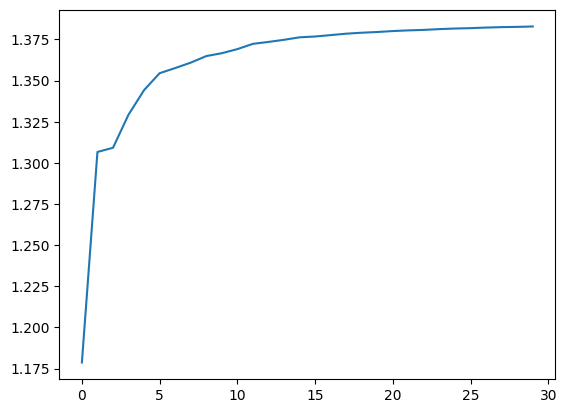

In [52]:
plt.plot(final_expectations)

In [53]:
final_expectations[-1]

1.3829109489692606

### Calculate normalisations

In [54]:
normalisations_by_layer = [
    inner_product_b_tensors(
        bs,
        left_environment=test.right_projected_symmetry_state
    )
    for bs in top_b_tensors
]

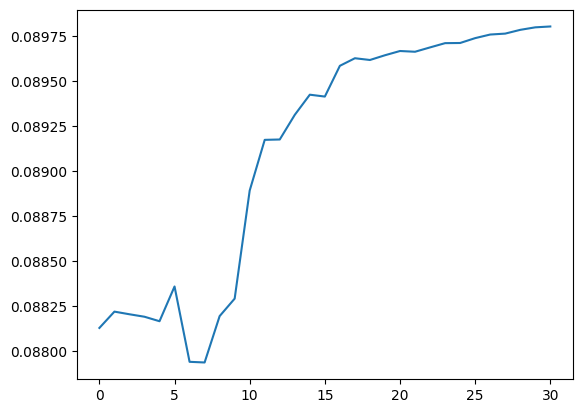

In [55]:
plt.plot(np.abs(np.array(normalisations_by_layer)))

Small amount of drift, 2%

In [56]:
normalisations_by_layer[-1]/normalisations_by_layer[0]

(1.019022056564998-0j)

## Sweep on block width

In [57]:
expectations = list()

for i in range(2, 7):
    print(f"Block width: {i}")
    expectations.append(list())
    bs = [
        test_psi.get_B(i)
        for k, i in enumerate(range(test.right_symmetry_index + 1, test.right_symmetry_index + 26))
    ]

    left_schmidt_values = [
        test_psi.get_SL(i)
        for _, i in enumerate(range(test.right_symmetry_index + 1, test.right_symmetry_index + 26))
    ]

    left_environment = test.right_projected_symmetry_state
    bottom_b_tensors = bs
    top_b_tensors = [bs,]
    left_schmidt_values_list = [left_schmidt_values,]
    block_width = i
    previous_mpo_w_tensors = []
    num_iterations = 3

    for i in range(30):
        if i%5 == 0:
            print(f"Layer: {i}")
    
        offset = i % block_width
    
        new_top_b_tensors, new_schmidt_values = optimise_layer(
            left_environment,
            top_b_tensors[-1],
            left_schmidt_values_list[-1],
            block_width,
            offset,
            expectations[-1],
            previous_mpo_w_tensors,
            bottom_b_tensors,
            num_iterations
        )
    
        top_b_tensors.append(new_top_b_tensors)
        left_schmidt_values_list.append(new_schmidt_values)

Block width: 2
Layer: 0
Layer: 5
Layer: 10
Layer: 15
Layer: 20
Layer: 25
Block width: 3
Layer: 0
Layer: 5
Layer: 10


KeyboardInterrupt: 

In [ ]:
final_expectations = list()

for l in expectations:
    final_expectations.append(list())
    for l1 in l:
        final_expectations[-1].append(l1[-1][-1])

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))

for i, l in enumerate(final_expectations, start=2):
    plt.plot(l, label=i)

ax.legend()

In [ ]:
final_expectations[-1][-1]

### Block width 7

In [45]:
bs = [
    test_psi.get_B(i)
    for k, i in enumerate(range(test.right_symmetry_index + 1, test.right_symmetry_index + 36))
]

In [46]:
left_schmidt_values = [
    test_psi.get_SL(i)
    for _, i in enumerate(range(test.right_symmetry_index + 1, test.right_symmetry_index + 36))
]

In [47]:
len(bs)

35

In [48]:
left_environment = test.right_projected_symmetry_state
bottom_b_tensors = bs
top_b_tensors = [bs,]
left_schmidt_values_list = [left_schmidt_values,]
block_width = 7
expectations = list()
previous_mpo_w_tensors = []
num_iterations = 3

In [49]:
def get_physical_dim(tensor, p_label='p'):
    index = tensor.get_leg_index(p_label)
    dim = tensor.shape[index]
    return dim

In [50]:
def mpo_unitarity_score(mpo_tensors):
    dims = [get_physical_dim(w, p_label='p') for w in mpo_tensors]

    w = mpo_tensors[0].take_slice(0, 'vL')
    dim = dim = get_physical_dim(w, p_label='p')

    t1 = w
    t1 = npc.tensordot(t1, w.conj(), [['p', 'p*'], ['p*', 'p']])
    t1 /= dim

    t2 = w
    t2 = npc.tensordot(t2, w.conj(), [['p',], ['p*',]])
    t2.ireplace_labels(['vR', 'vR*'], ['vR1', 'vR1*'])
    t2 = npc.tensordot(t2, w, [['p',], ['p*',]])
    t2 = npc.tensordot(t2, w.conj(), [['p', 'p*'], ['p*', 'p']])
    t2 /= dim

    for w in mpo_tensors[1:]:
        dim = get_physical_dim(w, p_label='p')

        t1 = npc.tensordot(t1, w, [['vR', ], ['vL']])
        t1 = npc.tensordot(t1, w.conj(), [['vR*', 'p', 'p*'], ['vL*', 'p*', 'p']])
        t1 /= dim

        t2 = npc.tensordot(t2, w, [['vR', ], ['vL']])
        t2 = npc.tensordot(t2, w.conj(), [['vR*', 'p',], ['vL*', 'p*',]])
    
        w = w.replace_label('vR', 'vR1')
        t2 = npc.tensordot(t2, w, [['vR1', 'p'], ['vL', 'p*']])
        t2 = npc.tensordot(t2, w.conj(), [['vR1*', 'p', 'p*'], ['vL*', 'p*', 'p']])
        t2 /= dim

    e1 = t1[0,0]
    e2 = t2[0,0,0,0]

    return e2 - 2*e1 +1

In [51]:
unitarity_scores = list()

In [52]:
for i in range(50):
    if i%5 == 0:
        print(f"Layer: {i}")
    
    offset = i % block_width

    new_top_b_tensors, new_schmidt_values = optimise_layer(
        left_environment,
        top_b_tensors[-1],
        left_schmidt_values_list[-1],
        block_width,
        offset,
        expectations,
        previous_mpo_w_tensors,
        bottom_b_tensors,
        num_iterations
    )

    top_b_tensors.append(new_top_b_tensors)
    left_schmidt_values_list.append(new_schmidt_values)

    unitarity_scores.append(mpo_unitarity_score(previous_mpo_w_tensors))

Layer: 0
Layer: 5
Layer: 10
Layer: 15
Layer: 20
Layer: 25
Layer: 30
Layer: 35
Layer: 40
Layer: 45


In [53]:
expectations[1]

[[1.3497803090234535,
  1.391183983292805,
  1.3913084934125843,
  1.3913091385975656,
  1.391309139692269,
  1.3913091397115354],
 [1.3913091397115738,
  1.3913095384147582,
  1.3913096398555804,
  1.3913096505499745,
  1.3913096505811249,
  1.3913096505815983],
 [1.3913096505815978,
  1.3913096586378046,
  1.3913096626617594,
  1.3913096633233537,
  1.3913096633277666,
  1.391309663327815]]

In [54]:
final_expectations = list()

for l in expectations:
    if l:
        final_expectations.append(l[-1][-1])

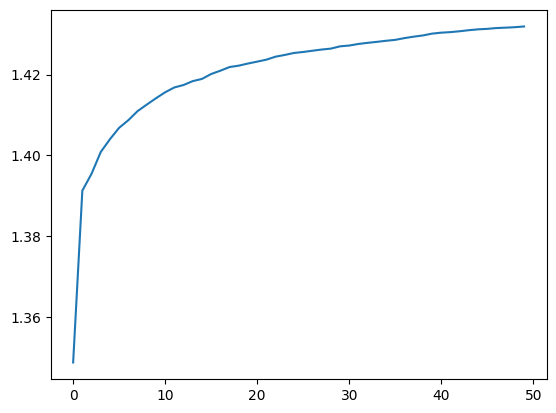

In [55]:
plt.plot(final_expectations)

In [56]:
final_expectations[-1]

1.4318933645782488

In [57]:
normalisations_by_layer = [
    inner_product_b_tensors(
        bs,
        left_environment=test.right_projected_symmetry_state
    )
    for bs in top_b_tensors
]

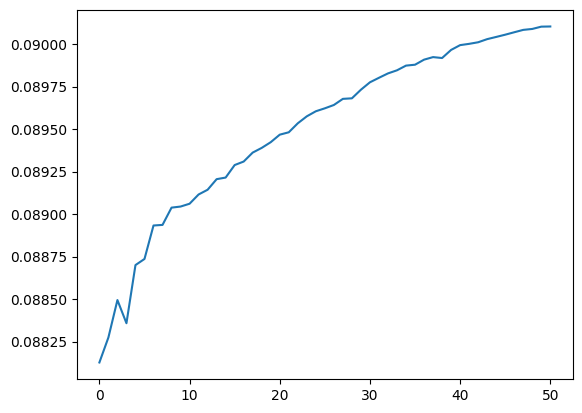

In [58]:
plt.plot(np.abs(np.array(normalisations_by_layer)))

The normalisation has a tendency to increase... why?

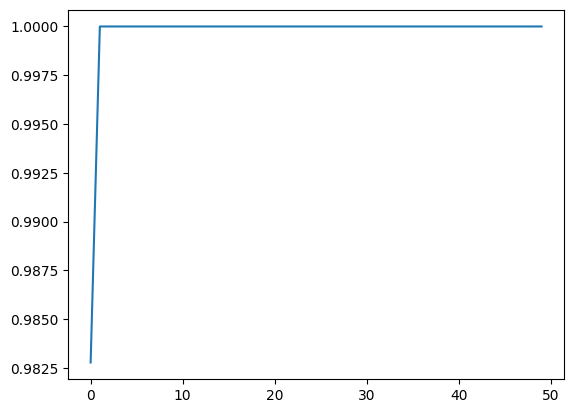

In [59]:
plt.plot(np.real(np.array(unitarity_scores)))

Unitarity does not seem to be preserved..., even at the first layer. Something is up. So the truncation scheme does not work well. Need to test properly.

In [95]:
len(unitarity_scores)

50